# PDF Fitting and Error bars

We start off by importing the required libraries

In [2]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Required libraries for data arrays, data manipulation, plotting etc
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}",r'\boldmath']


#sns.set(style="white", palette="muted")
#sns.set_context("paper")


## Data Import

In [3]:
big_1 = pd.read_csv("../results", sep=" ")
big_1.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


The **area** column is not actually area, but for the 3D axisymmetric solver, the `dv` volume element corresponds to volume per unit radian. Thus, all integral quantities (e.g. drop volume) need to be multiplied by a factor of $2\pi$. 

> The volume of the ligaments in our case are $\pi R^2 L$, where $R=1$. Thus, $\pi L$ gives us the initial ligament volume, where $L=2\Lambda$. 

In [4]:
# slicing the old dataset
# d1 : small amp - small aspect

d1 = big_1.loc[(big_1.amplitude == 0.1) & (big_1['aspect-ratio'] == 50)]

#viewing the new dataset
d1.head()

# Checking the volume of the ligaments at time T = 0, mean and std
d1.area.loc[d1.time == 0].mean() , d1.area.loc[d1.time == 0].std()


,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


(100.1493065950002, 1.2641804703570183)

## Volume correction and diameter computation

Now let us recompute the *volume* of the drops ("area"), by multiplying with $2\pi$, and recompute the diameters using the new volumes. We create a function that applies this to the dataset. The **area** column in this dataset is already multiplied by $2.0$, thus we just need to further multiply by $\pi$. 

In [5]:
# Create a function that modifies the volume ("area" column), then computes the new diameters
def volume_3d(df):
    df.area = df.area * np.pi
    df.diameter = ((6.0*df.area)/np.pi)**(1.0/3.0)
    return df

In [6]:
d1_new = d1.apply(volume_3d, axis='columns')
d1_new.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50.0,0.5,0.1,0.0,1.0,49.4770,0.000000,316.703955,8.457038,761.60000,100.0000,7797.0
1,0.01,50.0,0.5,0.1,6.0,1.0,49.4352,-0.000002,325.016610,8.530392,791.78400,100.0000,828.0
2,0.01,50.0,0.5,0.1,12.0,1.0,49.2898,0.000295,320.178557,8.487853,774.17600,100.0000,2487.0
3,0.01,50.0,0.5,0.1,18.0,13.0,93.7334,-0.081582,32.583028,3.962759,25.13270,27.0941,190.0
4,0.01,50.0,0.5,0.1,18.0,12.0,84.5200,-0.878589,5.966513,2.250301,1.96938,9.2134,181.0


Now we extract the diameters column from the huge dataset. 

In [7]:
# choose the time slice for the droplet ensemble
time = 24

# assign the corresponding droplet ensemble to a new numpy array
D = d1_new.diameter[d1_new.time == time].to_numpy()
np.shape(D)

(211830,)

Let us do a check by plotting the histogram for `D`. 

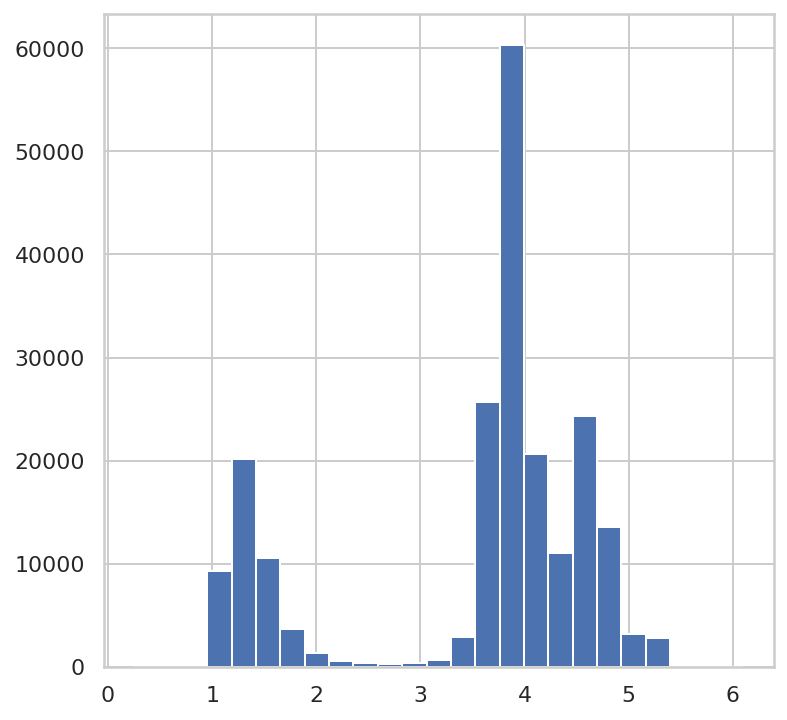

In [8]:
plt.figure(figsize=(6,6))
plt.hist(D,bins=25) ; 

In [11]:
print(np.mean(sample), np.std(sample))

1.7599828143343954 0.0019010217804395347


## Bootstrap resampling of bin-heights

In [53]:
def ensemble_heights(data, size_per_sample, n_samples , n_bins):
    
    ensemble_list = [] # create the empty list for creating the ensemble
    mean_heights_ensemble = []

    for _ in range(n_samples): 
        sample_n = np.random.choice(D, size = size_per_sample)
        heights_sample_n , bins_sample_n = np.histogram(sample_n, bins=n_bins)
        ensemble_list.append(heights_sample_n)

    heights_ensemble = np.array(ensemble_list)
    
    for i in range(n_bins):
        mean_height_bin_n = np.mean(heights_ensemble[:,i])
        mean_heights_ensemble.append(mean_height_bin_n)

    return np.array(mean_heights_ensemble)

In [55]:
def ensemble_error_heights(n_bootstrap, data , size_per_sample , n_samples, n_bins):

    bootstrap_list = []

    for i in range(n_bootstrap):
        mean_heights_ensemble_n = ensemble_heights(data , size_per_sample , n_samples, n_bins)
        bootstrap_list.append(mean_heights_ensemble_n)

    mean_heights_bootstrap = np.array(bootstrap_list)

    error_heights_bootstrap = []
    
    for i in range(n_bins):
        error_mean_height_bin_n = np.std(mean_heights_bootstrap[:,i])
        error_heights_bootstrap.append(error_mean_height_bin_n)

    standard_error_mean_heights = np.array(error_heights_bootstrap)

    return standard_error_mean_heights

In [57]:
a = ensemble_heights(D,10000 , 50 , 25)
print(a)

[5.78000e+00 1.30000e+00 3.51400e+01 4.91000e+02 8.66580e+02 4.77160e+02
 1.75560e+02 6.93400e+01 3.01800e+01 1.63200e+01 1.12200e+01 1.16000e+01
 1.77600e+01 4.28800e+01 2.54640e+02 1.54806e+03 2.38982e+03 9.25140e+02
 5.09060e+02 9.74640e+02 7.31580e+02 2.18500e+02 1.42100e+02 4.71600e+01
 7.48000e+00]


In [85]:
error = ensemble_error_heights(50 , D , 100000 , 100 , 25)
print(1.96*error, np.shape(error))

[1.33918933e+00 7.80970750e-01 9.95091209e+00 1.48445498e+02
 3.83273176e+01 1.10568919e+02 4.32648348e+01 1.94228184e+01
 6.85353944e+00 2.86677874e+00 2.88854182e+00 4.07430468e+00
 1.08240819e+01 8.09941963e+01 8.23102975e+02 7.47807930e+02
 1.21807104e+03 1.14725394e+02 4.77423087e+02 4.74999038e+02
 2.87498796e+02 1.89343113e+01 9.33802987e+01 7.67738921e+00
 1.46054886e+00] (25,)


In [89]:
sample_new = np.random.choice(D, size = 100000)
bins_2 = np.linspace(0.0, np.amax(sample_new), 26)

bins_centers = np.array([0.5 * (bins_2[i] + bins_2[i+1]) for i in range(len(bins_2)-1)])

#print(error_2)

<Figure size 576x576 with 0 Axes>

<ErrorbarContainer object of 3 artists>

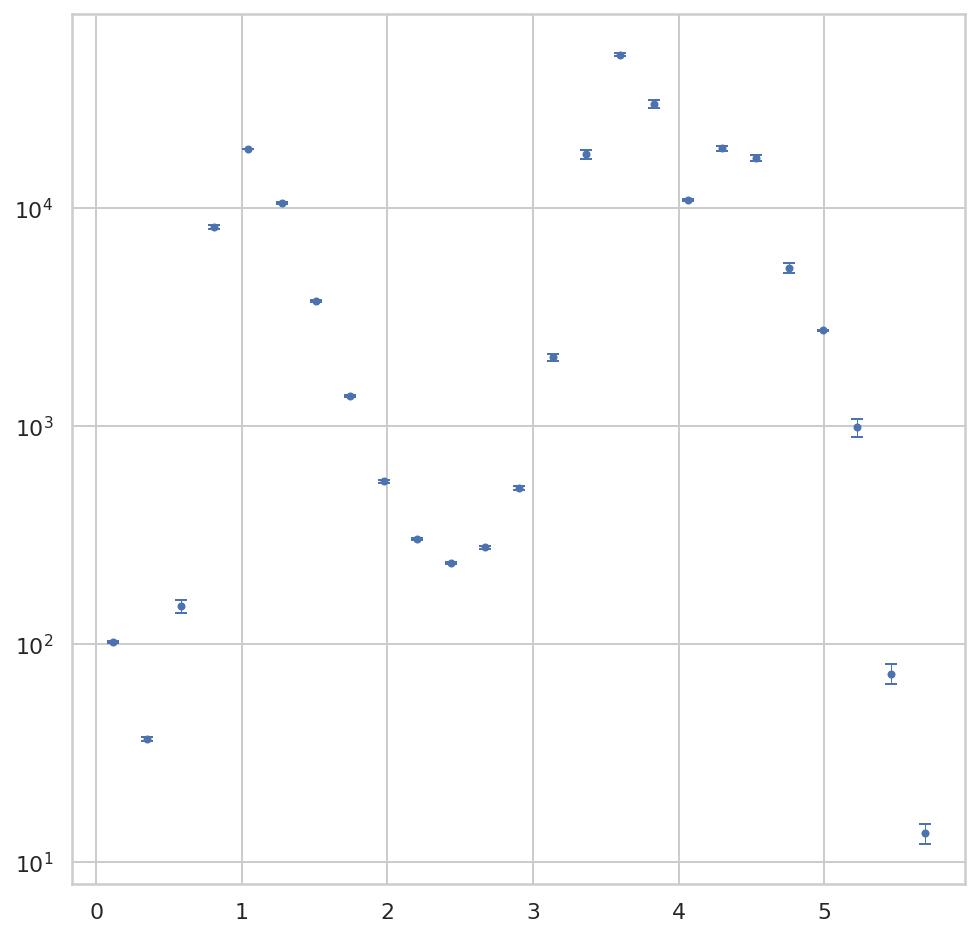

In [94]:
plt.figure(figsize=(8,8))
plt.errorbar(bins_centers, heights, yerr= 1.96 * error, marker = 'o', markersize = 3.0 , 
            linestyle = 'none', elinewidth=0.5, capsize=3.0);
plt.yscale('log', basey = 10);
plt.savefig("test_2.png", dpi= 200)

#plt.axvline(3.8)

#print(heights);
#print(errors);


## Things to do : 
- choose different sample size to reduce standard error
- maybe change number of bins to get better error bars
- rescale by 2.0 for all diameters 
- redo analysis and replot for other time slices
- compute PDFs and fit near tail region